In [3]:
from torchvision import models # здесь лежат предобученные сетки

#import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image 
import time
import scipy
from google.colab import files

# Библиотеки Pytorch
import torch 
import torchvision
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
from torch.autograd import Variable # для автоматического дифференциатора

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Перенос стиля



In [77]:
config = SimpleNamespace() # Создаем базовый класс пространства имен
config.content = '/content/drive/My Drive/Colab Notebooks/Базы/Style3.jpg' # наша основная картинка
config.style = '/content/drive/My Drive/Colab Notebooks/Базы/Style1.jpg' # наша стилизованная картинка
config.maxSize = 400 # максимально допустимый размер изображения
config.totalStep = 800 # общее количество шагов за эпоху
config.step = 10 # шаг
config.sampleStep = 100 # шаг для сохранения образца
config.styleWeight = 100 #вес на стиль
config.lr = .003 

In [78]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
device

device(type='cuda')

In [80]:
class PretrainedNet(nn.Module):
    def __init__(self):
        # Инициализируем нашу модель
        super(PretrainedNet, self).__init__()
        self.select = [1, 3, 8, 11, 14] # те слои, через которые мы будем пропускать свое изображение
        self.pretrainedNet = models.vgg19(pretrained=True).to(device) # подгружаем предобученную сетку
        
    def forward(self, x):
        features = [] # Извлекаем по индексам, которые мы прописали выше, feature map из сетки
        output = x
        for layerIndex in range(len(self.pretrainedNet.features)):
          output = self.pretrainedNet.features[layerIndex](output)
          if layerIndex in self.select:
            features.append(output)
        return features

In [81]:
def load_image(image_path, transform=None, maxSize=None, shape=None):
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Если указан максимальный размер, то меняем размер нашего изображения
    if maxSize:
        scale = maxSize / max(image.size) # задаем масштаб для преобразования размера
        size = np.array(image.size) * scale # масштабированный размер
        image = image.resize(size.astype(int), Image.ANTIALIAS) # преобразуем 
        
    # Если указана форма изображением, меняем форму
    if shape:
        image = image.resize(shape, Image.LANCZOS)

    # Если указаны методы трансформирования, то применяем его
    if transform:
        image = transform(image).unsqueeze(0) # трансформировали + вытянули до батча
    
    return image.to(device)

In [82]:
# Методы трансформирования изображения
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [83]:
# Загружаем оригинал и стиль для картинок, применив нужные методы
content = load_image(config.content, transform, maxSize=config.maxSize)
style = load_image(config.style, transform, shape=[content.size(2), content.size(3)])

In [84]:
# Создаем место под тензор для конечной картинки, указываем, что дифференцируем 
target = content.clone().requires_grad_(True)

In [85]:
target.shape

torch.Size([1, 3, 400, 266])

In [86]:
model = PretrainedNet().eval() # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=0.1) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()

In [87]:
for step in range(config.totalStep):
    # Для каждого из изображений извлекаем feature map
    targetFeatures = model.forward(target)
    contentFeatures = model.forward(content) 
    styleFeatures = model.forward(style)
    
    styleLoss = 0
    contentLoss = 0

    for f1, f2, f3 in zip(targetFeatures, contentFeatures, styleFeatures):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += contentCriteria(f1, f2)
        #print(contentLoss)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, c, h, w = f1.size() # пропускаем batch
        f1 = f1.reshape(c, h*w).to(device) 
        f3 = f3.reshape(c, h*w).to(device)

        # Находим матрицу Грама для конечной и стиля
        f1 = torch.mm(f1, f1.t()) 
        f3 = torch.mm(f3, f3.t())

        # Потери для стиля и конечной картинки
        kf = 0.8 # коэффициент преобладание стиля
        styleLoss += contentCriteria(f1,f3) * 0.8
        
    # Прописываем конечную функцию потерь 
    loss = styleLoss + contentLoss
    #print(betta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (step+1) % config.step == 0:
        print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля: {}' 
               .format(step+1, config.totalStep, contentLoss.item(), styleLoss.item()))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.clone().squeeze() # создаем место под тензор
        img = img.clamp_(0, 1) # оставить значения, попадающие в диапазон между 0,1
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/800], Ошибка для оригинала: 29.0082, Ошибка для стиля: 1552944512.0
Шаг [20/800], Ошибка для оригинала: 31.0272, Ошибка для стиля: 703158656.0
Шаг [30/800], Ошибка для оригинала: 32.4331, Ошибка для стиля: 402108736.0
Шаг [40/800], Ошибка для оригинала: 33.0977, Ошибка для стиля: 265292192.0
Шаг [50/800], Ошибка для оригинала: 33.7587, Ошибка для стиля: 199166080.0
Шаг [60/800], Ошибка для оригинала: 34.5035, Ошибка для стиля: 157769184.0
Шаг [70/800], Ошибка для оригинала: 35.0159, Ошибка для стиля: 130672200.0
Шаг [80/800], Ошибка для оригинала: 35.3446, Ошибка для стиля: 111929488.0
Шаг [90/800], Ошибка для оригинала: 35.6279, Ошибка для стиля: 98111544.0
Шаг [100/800], Ошибка для оригинала: 35.8627, Ошибка для стиля: 87465560.0
Шаг [110/800], Ошибка для оригинала: 36.0613, Ошибка для стиля: 78942496.0
Шаг [120/800], Ошибка для оригинала: 36.2435, Ошибка для стиля: 71954496.0
Шаг [130/800], Ошибка для оригинала: 36.4126, Ошибка для стиля: 66080696.0
Шаг [140/800], Ошибка для

In [88]:
styled_img = target.cpu().detach().numpy()[0].transpose(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


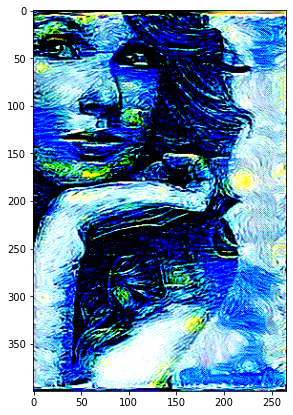

In [89]:
plt.figure(figsize=(14,7))
plt.imshow(styled_img)
plt.show()

# **Результат:**

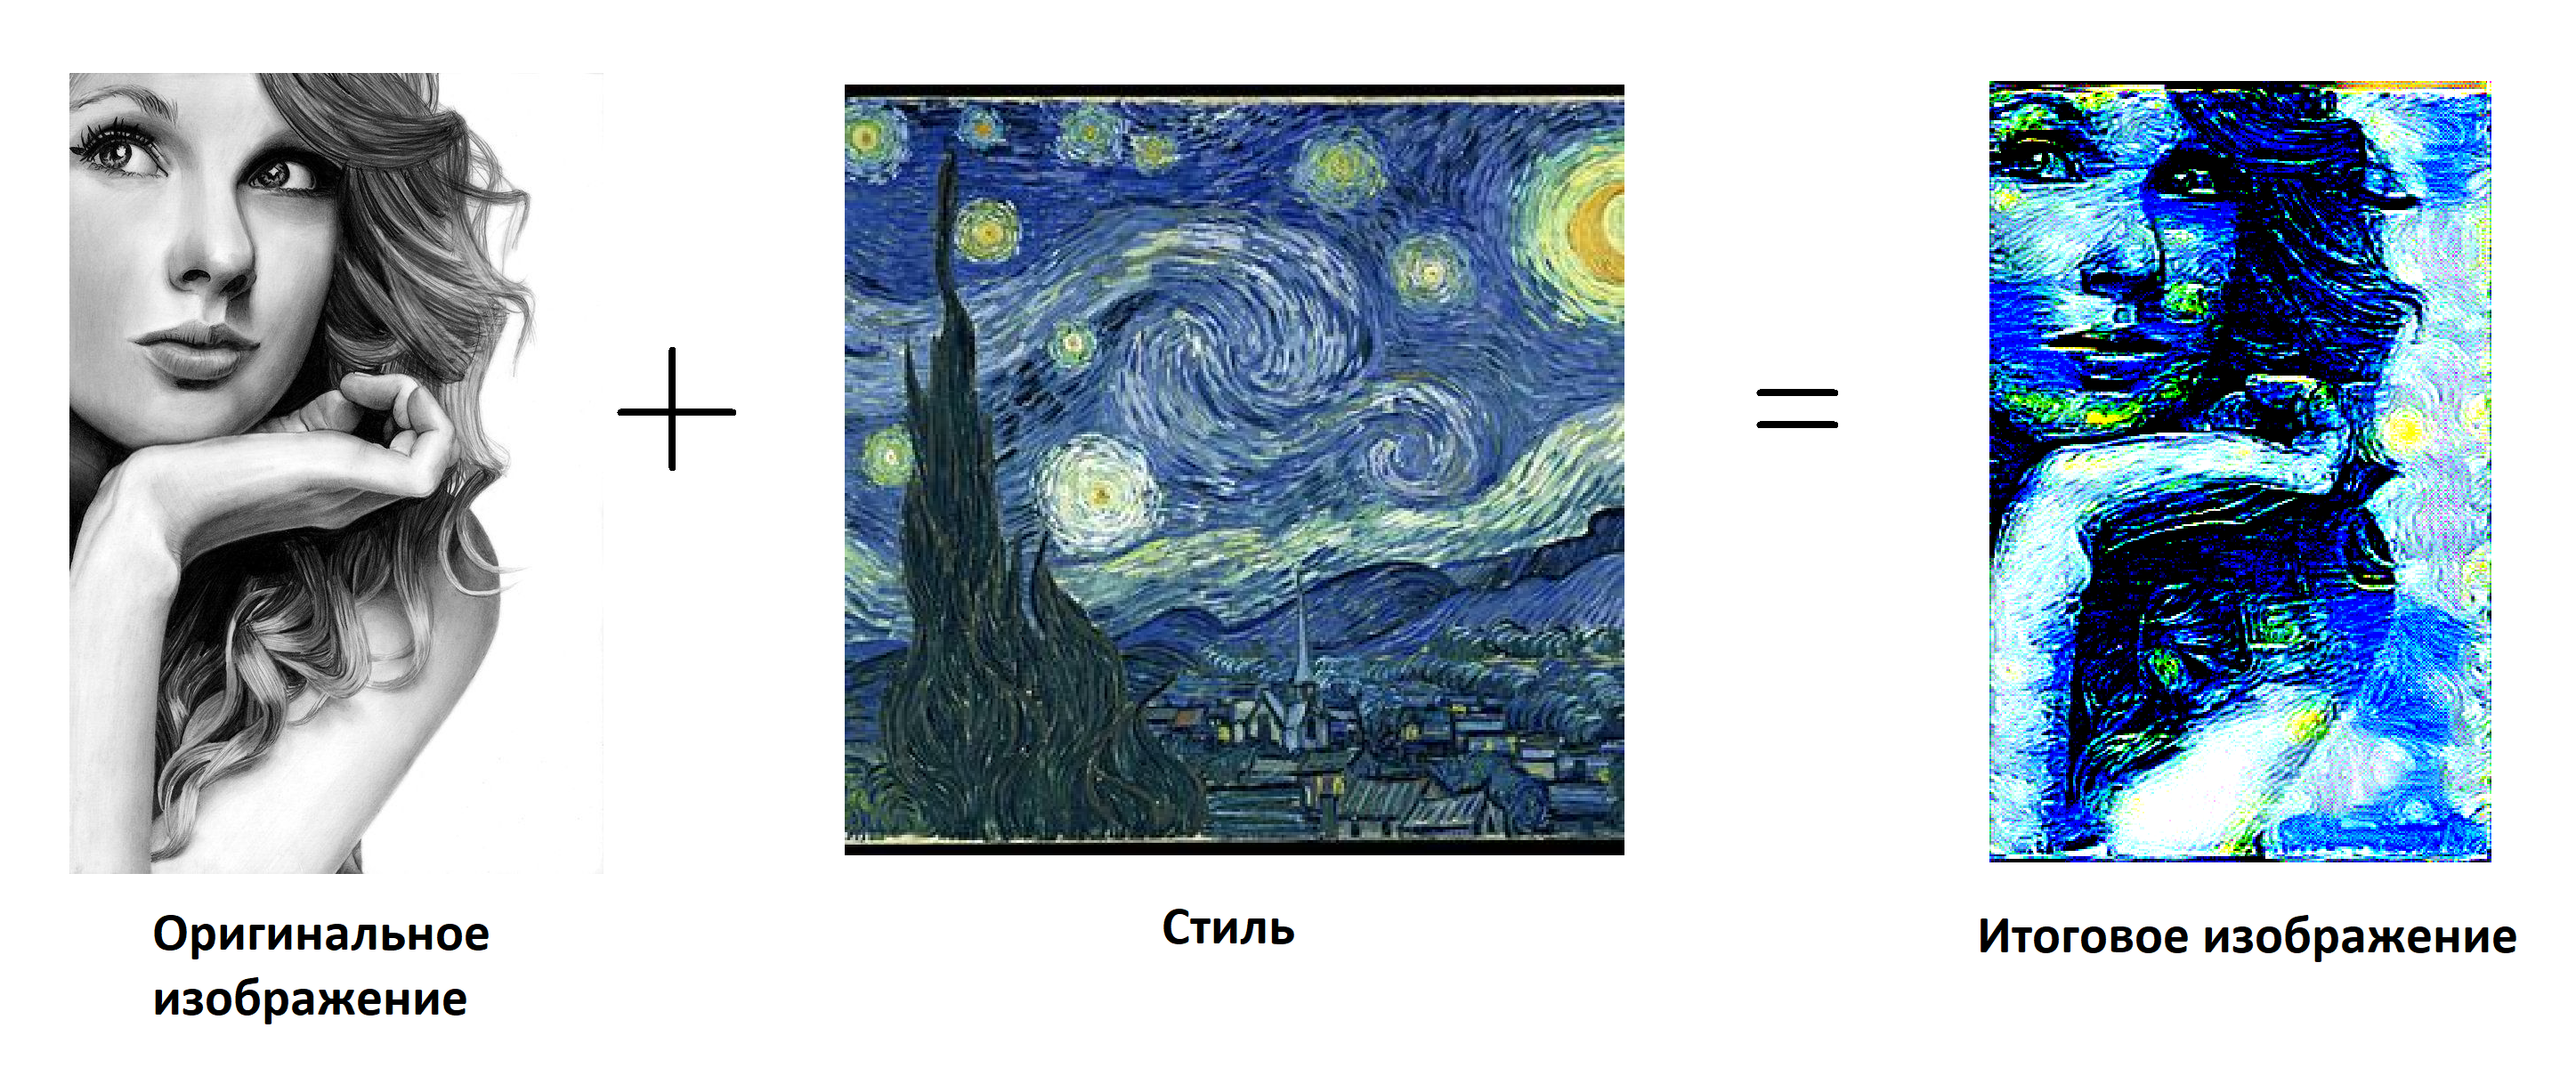